In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/lapraf/ML/Salary-prediction/venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <98D50080-9632-3EA4-B874-146E55453763> /Users/lapraf/ML/Salary-prediction/venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [2]:
df = pd.read_csv('avg_salary.csv')

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Period      76 non-null     float64
 1   Seniority   76 non-null     object 
 2   IT_Exports  76 non-null     float64
 3   CPI         76 non-null     float64
 4   GDP         76 non-null     float64
 5   Salary      76 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.7+ KB


In [4]:
df.head()

,Period,Seniority,IT_Exports,CPI,GDP,Salary
0,2015.12,Junior,1325.8,145.8,2094.473877,1064.500000
1,2015.12,Lead,1325.8,145.8,2094.473877,2371.555556
2,2015.12,Middle,1325.8,145.8,2094.473877,1655.376812
3,2015.12,Senior,1325.8,145.8,2094.473877,2540.357143
4,2016.06,Junior,1475.2,148.9,2158.461182,909.240000


In [5]:
df.dtypes

Period        float64
Seniority      object
IT_Exports    float64
CPI           float64
GDP           float64
Salary        float64
dtype: object

In [6]:
df.shape

(76, 6)

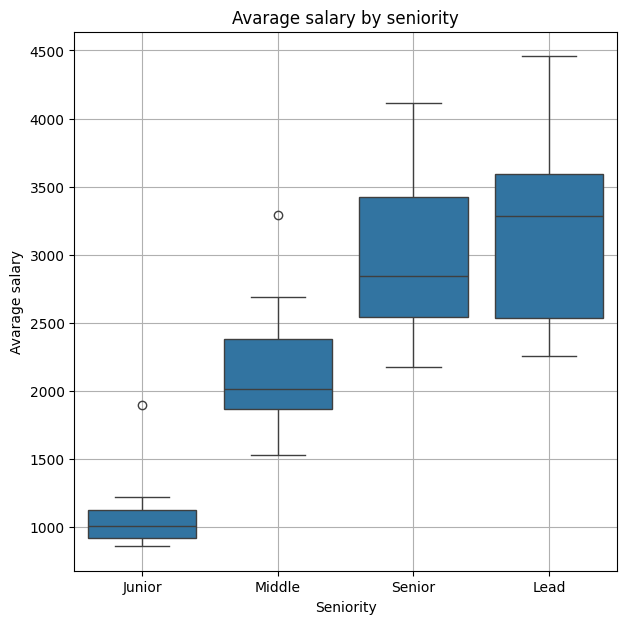

In [7]:
plt.figure(figsize=(7, 7))
sns.boxplot(df, x='Seniority', y = 'Salary', order = df.groupby('Seniority')['Salary'].mean().sort_values().index)
plt.title('Avarage salary by seniority')
plt.ylabel('Avarage salary')
plt.grid()
plt.show()

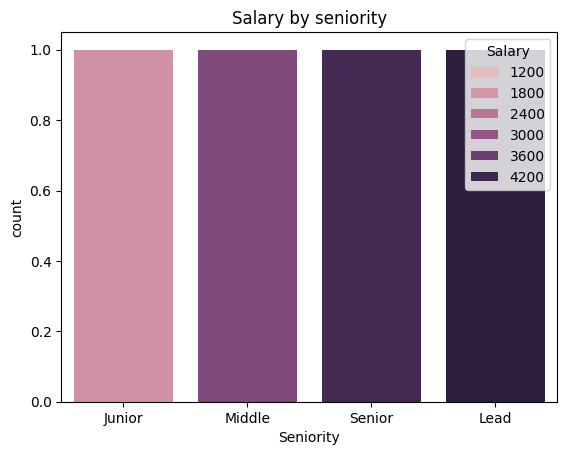

In [8]:
sns.countplot(x = df['Seniority'], hue = df['Salary'], dodge = False, order = df.groupby('Seniority')['Salary'].mean().sort_values().index, saturation = 1.5)
plt.title('Salary by seniority')
plt.show()

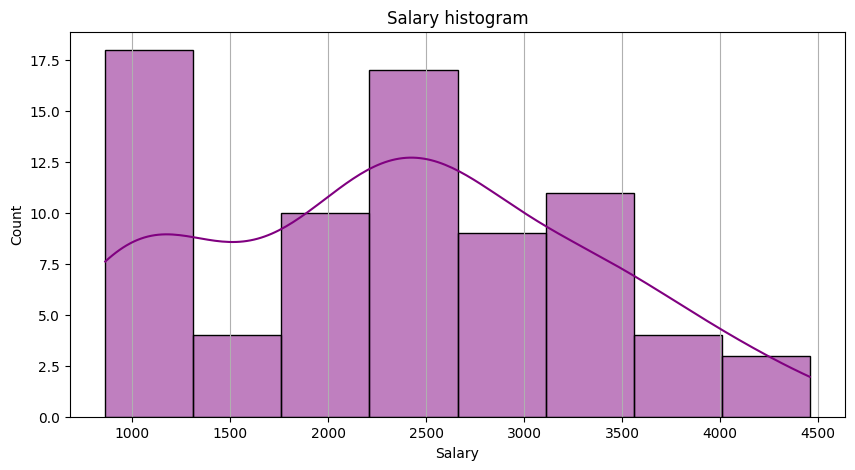

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Salary'], bins = 'auto', kde= True, color = 'purple', edgecolor = 'black')
plt.title('Salary histogram')
plt.grid(axis = 'x')
plt.show()

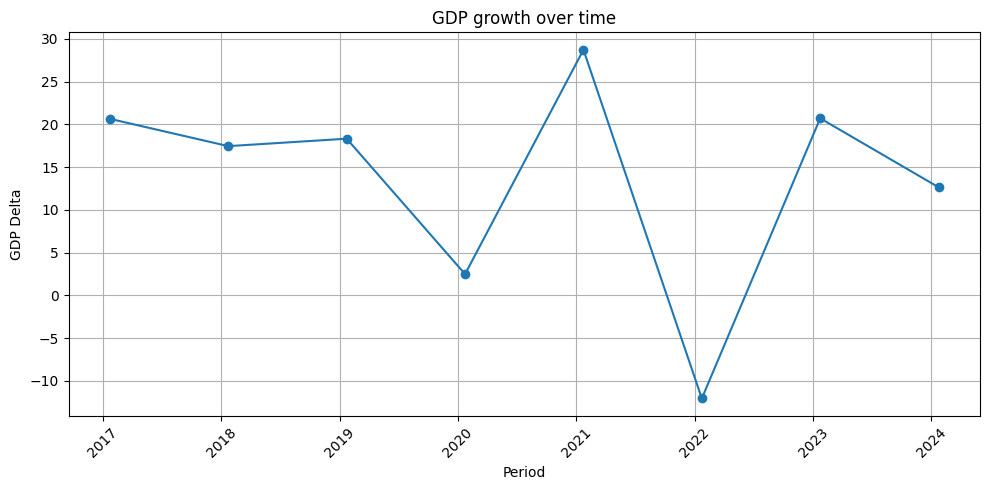

In [10]:
df_gdp = df[['Period', 'GDP']].drop_duplicates().sort_values('Period')
df_gdp = df_gdp[df_gdp['Period'].astype(str).str.endswith('.06')]
df_gdp['GDP Delta%'] = df_gdp['GDP'].pct_change() * 100
plt.figure(figsize=(10, 5))
plt.plot(df_gdp['Period'], df_gdp['GDP Delta%'], marker = 'o', linestyle = '-')
plt.title('GDP growth over time')
plt.xlabel('Period')
plt.ylabel('GDP Delta')
plt.xticks(rotation = 45)
plt.grid()
plt.tight_layout()
plt.show()

### Differentation

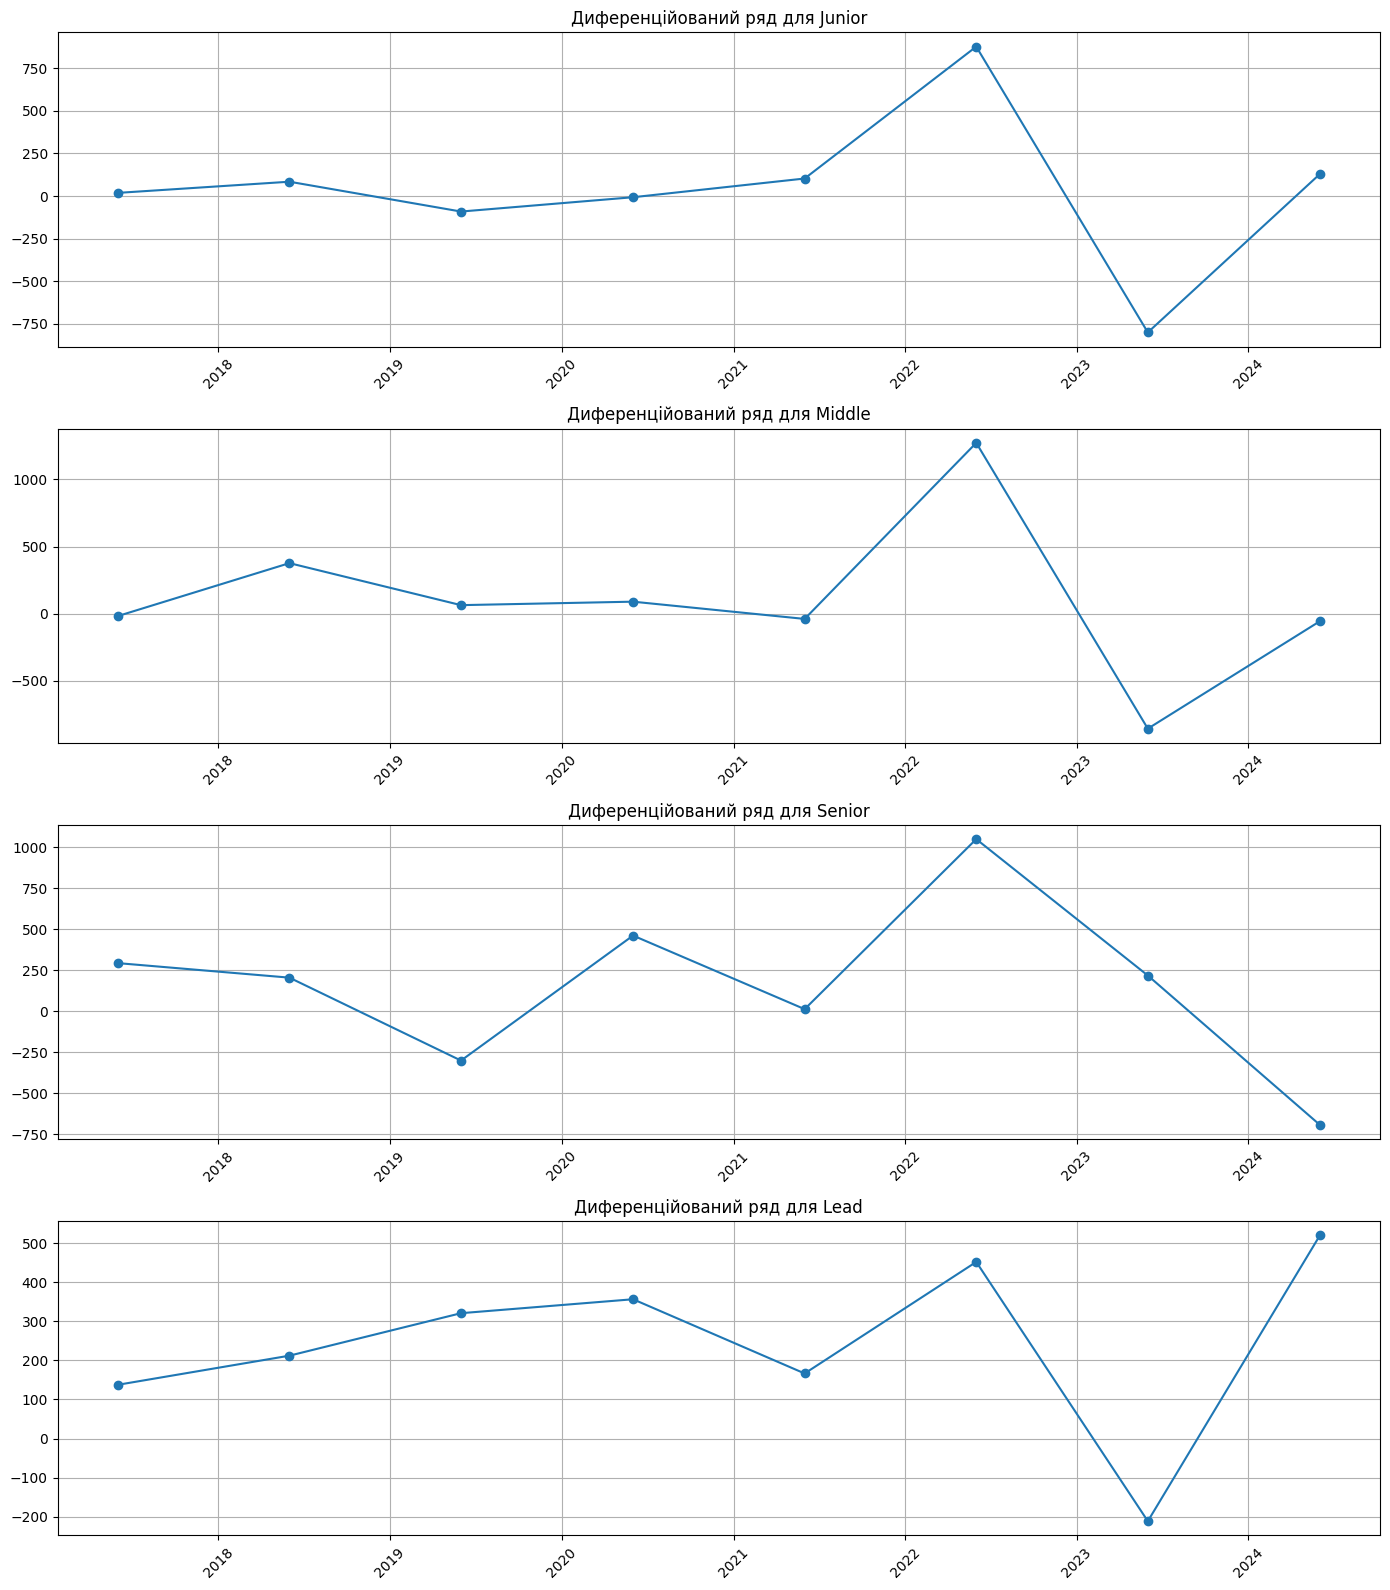

In [11]:
order = ['Junior', 'Middle', 'Senior', 'Lead']
unique_sen = [x for x in order if x in df['Seniority'].unique()]

plt.figure(figsize=(14, 4 * len(unique_sen)))

for i, level in enumerate(unique_sen, start=1):
    subset = df[(df['Seniority'] == level) & ((df['Period'] % 1).round(2) == 0.06)].copy()
    subset['Period_str'] = subset['Period'].apply(lambda x: f"{int(x)}.{int(round((x - int(x)) * 100)):02d}")
    subset['Period_dt'] = pd.to_datetime(subset['Period_str'], format='%Y.%m')
    d_series = subset['Salary'].diff().dropna()
    periods = subset['Period_dt'].iloc[1:]

    plt.subplot(len(unique_sen), 1, i)
    plt.plot(periods, d_series, marker='o')
    plt.title(f'Диференційований ряд для {level}')
    plt.grid()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Decomposition

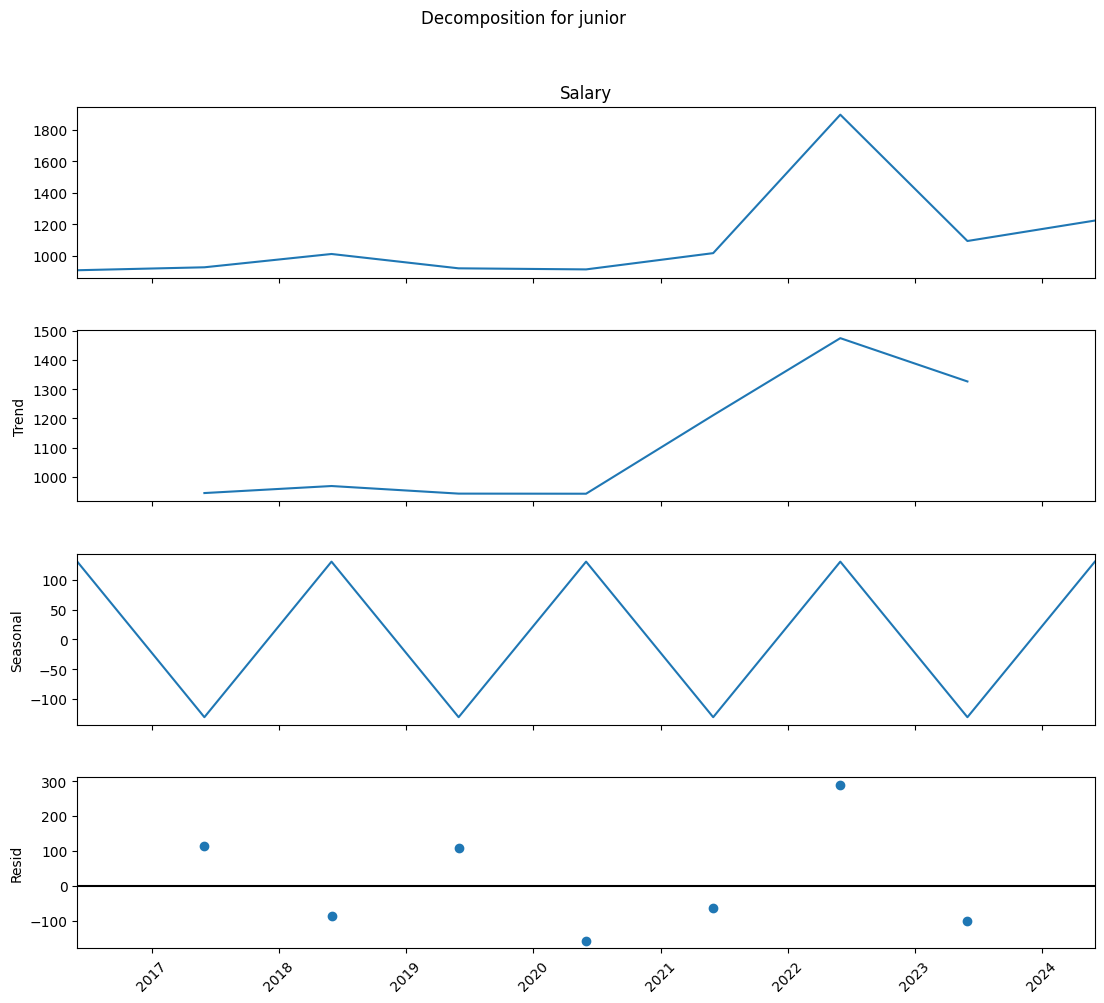

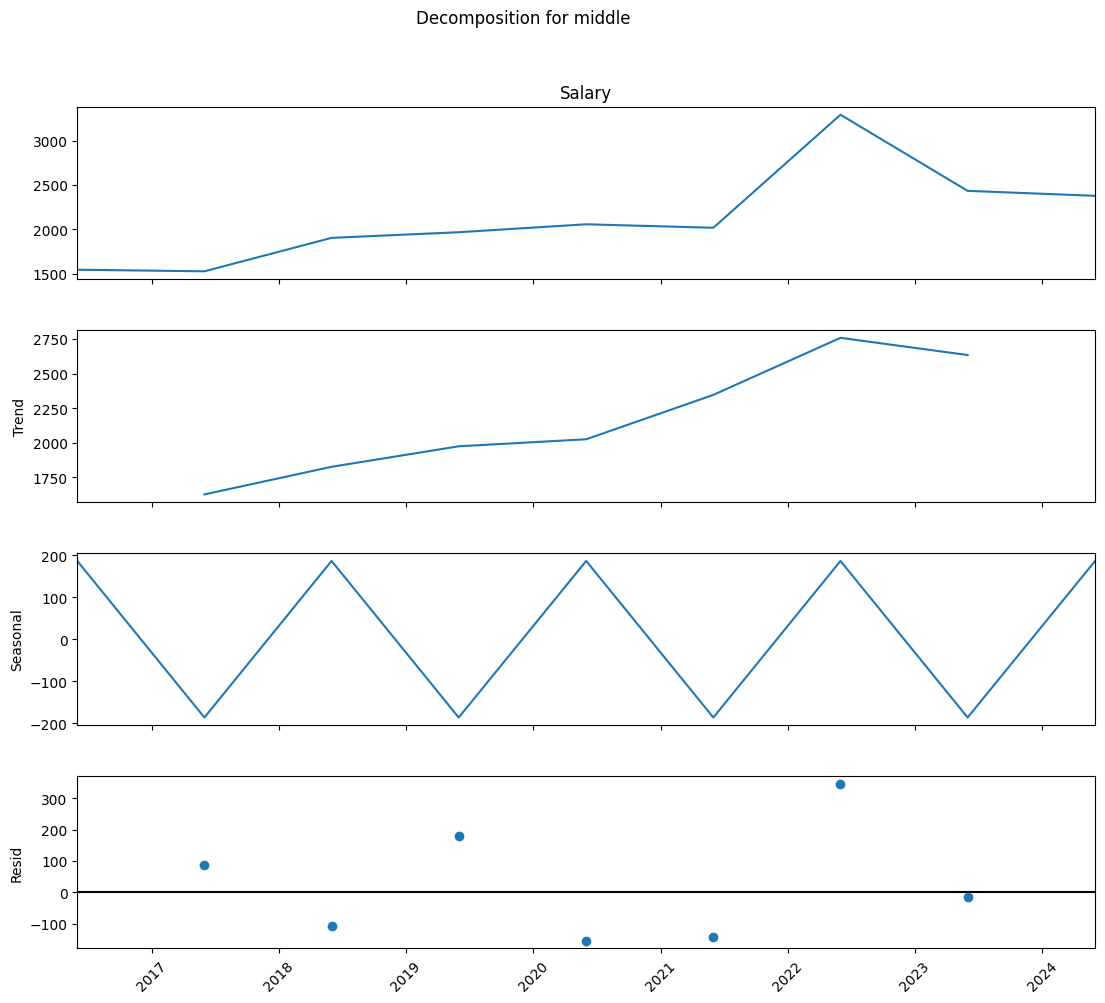

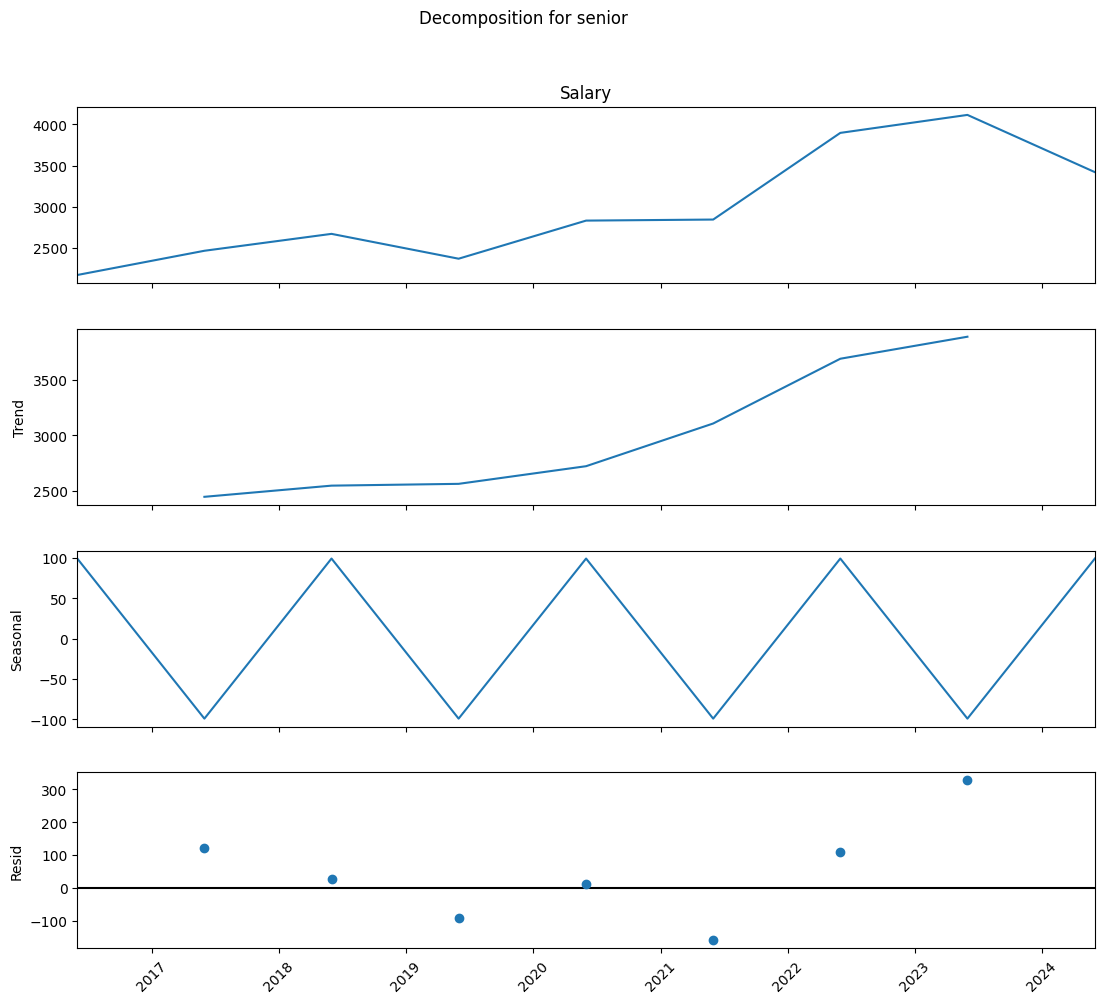

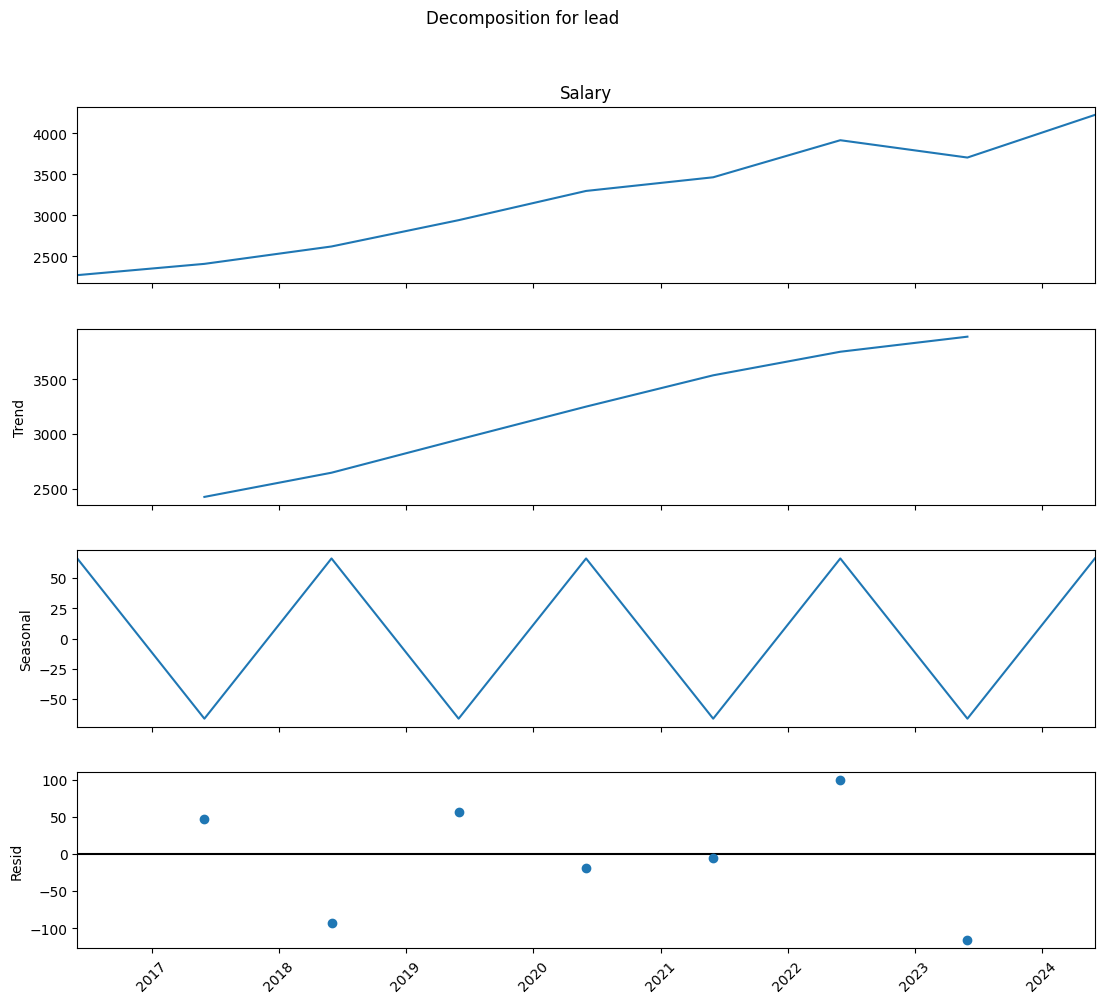

In [12]:
df['Seniority'] = df['Seniority'].str.strip().str.lower()

order = ['junior', 'middle', 'senior', 'lead']
unique_sen = [x for x in order if x in df['Seniority'].unique()]

for level in unique_sen:
    subset = df[(df['Seniority'] == level) & ((df['Period'] % 1).round(2) == 0.06)].copy()
    subset['Period_str'] = subset['Period'].apply(lambda x: f"{int(x)}.{int(round((x - int(x)) * 100)):02d}")
    subset['Period_dt'] = pd.to_datetime(subset['Period_str'], format='%Y.%m')
    subset.set_index('Period_dt', inplace=True)

    s_s = subset['Salary']

    decompose = seasonal_decompose(s_s, model='additive', period=2)

    fig = decompose.plot()
    fig.set_size_inches(12, 10)
    plt.suptitle(f'Decomposition for {level}', y=1.02)
    plt.xticks(rotation=45)
    plt.show()


In [13]:
results = []
df = df.copy()

for l in df['Seniority'].unique():
    subset = df[df['Seniority'] == l].copy()
    stl = STL(subset['Salary'], period = 2)
    res = stl.fit()
    subset['Cleaned'] = res.resid
    results.append(subset)
df_clean = pd.concat(results, ignore_index= True)

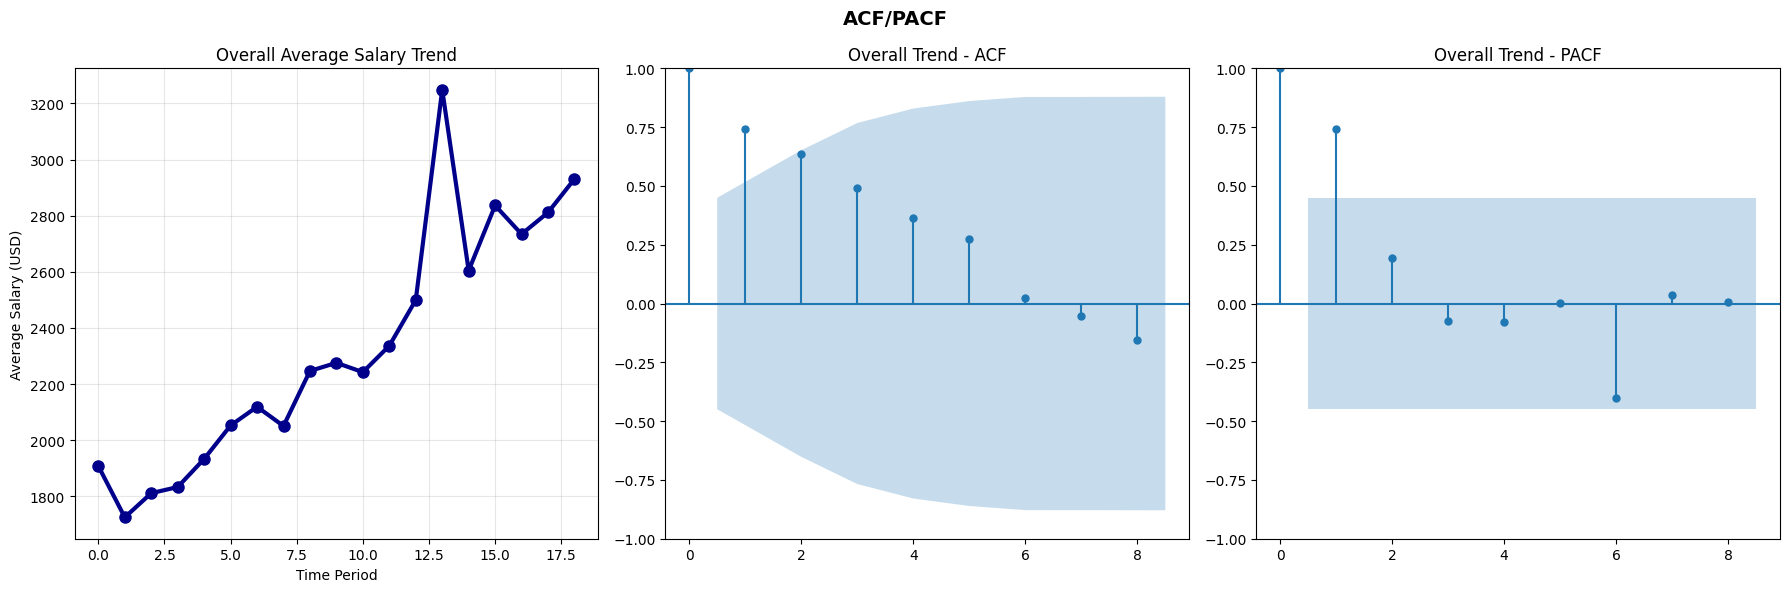

Overall trend statistics:
Data points: 19
Mean salary: $2326
Trend slope: 70.58 USD/period


In [14]:
overall_avg = df.groupby('Period')['Salary'].mean().reset_index()
overall_avg = overall_avg.sort_values('Period')

if len(overall_avg) >= 3:
    overall_series = overall_avg['Salary'].values
    
    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
    fig2.suptitle('ACF/PACF', 
                    fontsize=14, fontweight='bold')
    
    axes2[0].plot(range(len(overall_series)), overall_series, 
                    marker='o', linewidth=3, markersize=8, color='darkblue')
    axes2[0].set_title('Overall Average Salary Trend')
    axes2[0].set_xlabel('Time Period')
    axes2[0].set_ylabel('Average Salary (USD)')
    axes2[0].grid(True, alpha=0.3)
    
    max_lags_overall = min(len(overall_series) // 2, 8)
    
    plot_acf(overall_series, lags=max_lags_overall, ax=axes2[1], 
            title='Overall Trend - ACF')
    plot_pacf(overall_series, lags=max_lags_overall, ax=axes2[2], 
                title='Overall Trend - PACF')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Overall trend statistics:")
    print(f"Data points: {len(overall_series)}")
    print(f"Mean salary: ${overall_series.mean():.0f}")
    print(f"Trend slope: {stats.linregress(range(len(overall_series)), overall_series).slope:.2f} USD/period")
    

In [15]:
df['Period_Year'] = df['Period'].astype(int)
df['Period_Month'] = ((df['Period'] - df['Period_Year']) * 100).round().astype(int)

df['GDP_CPI_Ratio'] = df['GDP'] / df['CPI']
df['IT_Exports_per_GDP'] = df['IT_Exports'] / df['GDP']

print(f"\nFinal dataset shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")


Final dataset shape: (76, 10)
Features: ['Period', 'Seniority', 'IT_Exports', 'CPI', 'GDP', 'Salary', 'Period_Year', 'Period_Month', 'GDP_CPI_Ratio', 'IT_Exports_per_GDP']


In [16]:
def train_ml_model_for_seniority(df, seniority):
    
    df_sen = df[df['Seniority'] == seniority].copy()
    
    
    features = ['Period_Year', 'Period_Month', 'GDP', 'CPI', 'IT_Exports', 'GDP_CPI_Ratio', 'IT_Exports_per_GDP']
    X = df_sen[features]
    y = df_sen['Salary']
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
   
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    
    preds = model.predict(X_test)
    
    
    test_df = pd.DataFrame(X_test, index=X_test.index)
    
    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, preds))
    
    print(f"📊 {seniority.capitalize()} — MAE: {mae:.2f}, RMSE: {rmse_xgb:.2f}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(test_df.index, y_test.values, label='Actual')
    plt.plot(test_df.index, preds, label='Predicted', linestyle='--')
    plt.title(f"{seniority.capitalize()} — Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return model


In [18]:
feature_cols = ['Period_Year', 'Period_Month', 'IT_Exports', 'CPI', 'GDP', 'GDP_CPI_Ratio', 'IT_Exports_per_GDP', 'Seniority']
target_col = 'Salary'

X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

cat = ['Seniority']
num = [col for col in feature_cols if col not in cat]

print(f"\nCategorical features: {cat}")
print(f"Numerical features: {num}")


Features shape: (76, 8)
Target shape: (76,)

Categorical features: ['Seniority']
Numerical features: ['Period_Year', 'Period_Month', 'IT_Exports', 'CPI', 'GDP', 'GDP_CPI_Ratio', 'IT_Exports_per_GDP']


In [19]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num),
        ('cat', cat_transformer, cat)
    ]
)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Seniority']
)

print(X_train['Seniority'].value_counts())
print(X_test['Seniority'].value_counts())

Seniority
senior    15
junior    15
lead      15
middle    15
Name: count, dtype: int64
Seniority
middle    4
junior    4
lead      4
senior    4
Name: count, dtype: int64


In [21]:
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    ))
])

In [22]:
ensemble_model = VotingRegressor(
    estimators=[
        ('linear_reg', linear_pipeline),
        ('xgb_reg', xgb_pipeline)
    ],
    weights=None
)

In [23]:
print("Training Linear Regression...")
linear_pipeline.fit(X_train, y_train)

print("Training XGBoost...")
xgb_pipeline.fit(X_train, y_train)

print("Training Ensemble...")
ensemble_model.fit(X_train, y_train)

Training Linear Regression...
Training XGBoost...
Training Ensemble...


VotingRegressor(estimators=[('linear_reg',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Period_Year',
                                                                                'Period_Month',
                                                                                'IT_Exports',
                                                                                'CPI',
                                                                                'GDP',
                                                                                'GDP_CPI_Ratio',
                                                                                'IT_Exports_per_GDP']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Seniority']...
                                                           feature_weights=None,
                                                           gamma=None,
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.1,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=6,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=100,
                                                           n_jobs=None,
                                                           num_parallel_tree=None, ...))]))])

In [24]:
y_train_pred_linear = linear_pipeline.predict(X_train)
y_train_pred_xgb = xgb_pipeline.predict(X_train)
y_train_pred_ensemble = ensemble_model.predict(X_train)

y_test_pred_linear = linear_pipeline.predict(X_test)
y_test_pred_xgb = xgb_pipeline.predict(X_test)
y_test_pred_ensemble = ensemble_model.predict(X_test)


In [25]:
def evaluate_model(y_true, y_pred, model_name, dataset_name):
    """Evaluate model performance with multiple metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} - {dataset_name} Set:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  MSE:  {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

results = {}

results['Linear_Train'] = evaluate_model(y_train, y_train_pred_linear, "Linear Regression", "Training")
results['XGB_Train'] = evaluate_model(y_train, y_train_pred_xgb, "XGBoost", "Training")
results['Ensemble_Train'] = evaluate_model(y_train, y_train_pred_ensemble, "Ensemble", "Training")

results['Linear_Test'] = evaluate_model(y_test, y_test_pred_linear, "Linear Regression", "Test")
results['XGB_Test'] = evaluate_model(y_test, y_test_pred_xgb, "XGBoost", "Test")
results['Ensemble_Test'] = evaluate_model(y_test, y_test_pred_ensemble, "Ensemble", "Test")


Linear Regression - Training Set:
  MAE:  223.49
  MSE:  83824.57
  RMSE: 289.52
  R²:   0.9098

XGBoost - Training Set:
  MAE:  2.35
  MSE:  16.24
  RMSE: 4.03
  R²:   1.0000

Ensemble - Training Set:
  MAE:  112.24
  MSE:  21196.79
  RMSE: 145.59
  R²:   0.9772

Linear Regression - Test Set:
  MAE:  239.00
  MSE:  81295.91
  RMSE: 285.12
  R²:   0.9090

XGBoost - Test Set:
  MAE:  170.24
  MSE:  68800.04
  RMSE: 262.30
  R²:   0.9230

Ensemble - Test Set:
  MAE:  161.90
  MSE:  44723.09
  RMSE: 211.48
  R²:   0.9499


In [ ]:
import joblib


joblib.dump(xgb_pipeline, 'salary_model.joblib')

print("Model saved successfully!")


In [26]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost', 'Ensemble'],
    'Train_R2': [results['Linear_Train']['R2'], results['XGB_Train']['R2'], results['Ensemble_Train']['R2']],
    'Test_R2': [results['Linear_Test']['R2'], results['XGB_Test']['R2'], results['Ensemble_Test']['R2']],
    'Train_RMSE': [results['Linear_Train']['RMSE'], results['XGB_Train']['RMSE'], results['Ensemble_Train']['RMSE']],
    'Test_RMSE': [results['Linear_Test']['RMSE'], results['XGB_Test']['RMSE'], results['Ensemble_Test']['RMSE']],
})

print(comparison_df.round(4))

               Model  Train_R2  Test_R2  Train_RMSE  Test_RMSE
0  Linear Regression    0.9098   0.9090    289.5247   285.1244
1            XGBoost    1.0000   0.9230      4.0301   262.2976
2           Ensemble    0.9772   0.9499    145.5912   211.4783


In [27]:
feature_names = (num + list(ensemble_model.named_estimators_['linear_reg'].named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat)))

xgb_importance = xgb_pipeline.named_steps['regressor'].feature_importances_
xgb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_importance
}).sort_values('importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(xgb_feature_importance)

linear_coef = linear_pipeline.named_steps['regressor'].coef_
linear_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': linear_coef,
    'abs_coefficient': np.abs(linear_coef)
}).sort_values('abs_coefficient', ascending=False)

print("\nLinear Regression Coefficients:")
print(linear_feature_importance)


XGBoost Feature Importance:
              feature  importance
9    Seniority_senior    0.337251
7      Seniority_lead    0.254806
3                 CPI    0.142754
8    Seniority_middle    0.106215
4                 GDP    0.057498
2          IT_Exports    0.038300
5       GDP_CPI_Ratio    0.026485
0         Period_Year    0.024768
6  IT_Exports_per_GDP    0.007195
1        Period_Month    0.004729

Linear Regression Coefficients:
              feature  coefficient  abs_coefficient
7      Seniority_lead  2117.119314      2117.119314
9    Seniority_senior  1828.103891      1828.103891
4                 GDP  1455.205190      1455.205190
5       GDP_CPI_Ratio -1038.079701      1038.079701
8    Seniority_middle  1010.584552      1010.584552
0         Period_Year  -785.745470       785.745470
3                 CPI   714.959505       714.959505
6  IT_Exports_per_GDP   131.216944       131.216944
1        Period_Month  -112.174022       112.174022
2          IT_Exports   -11.481545        11

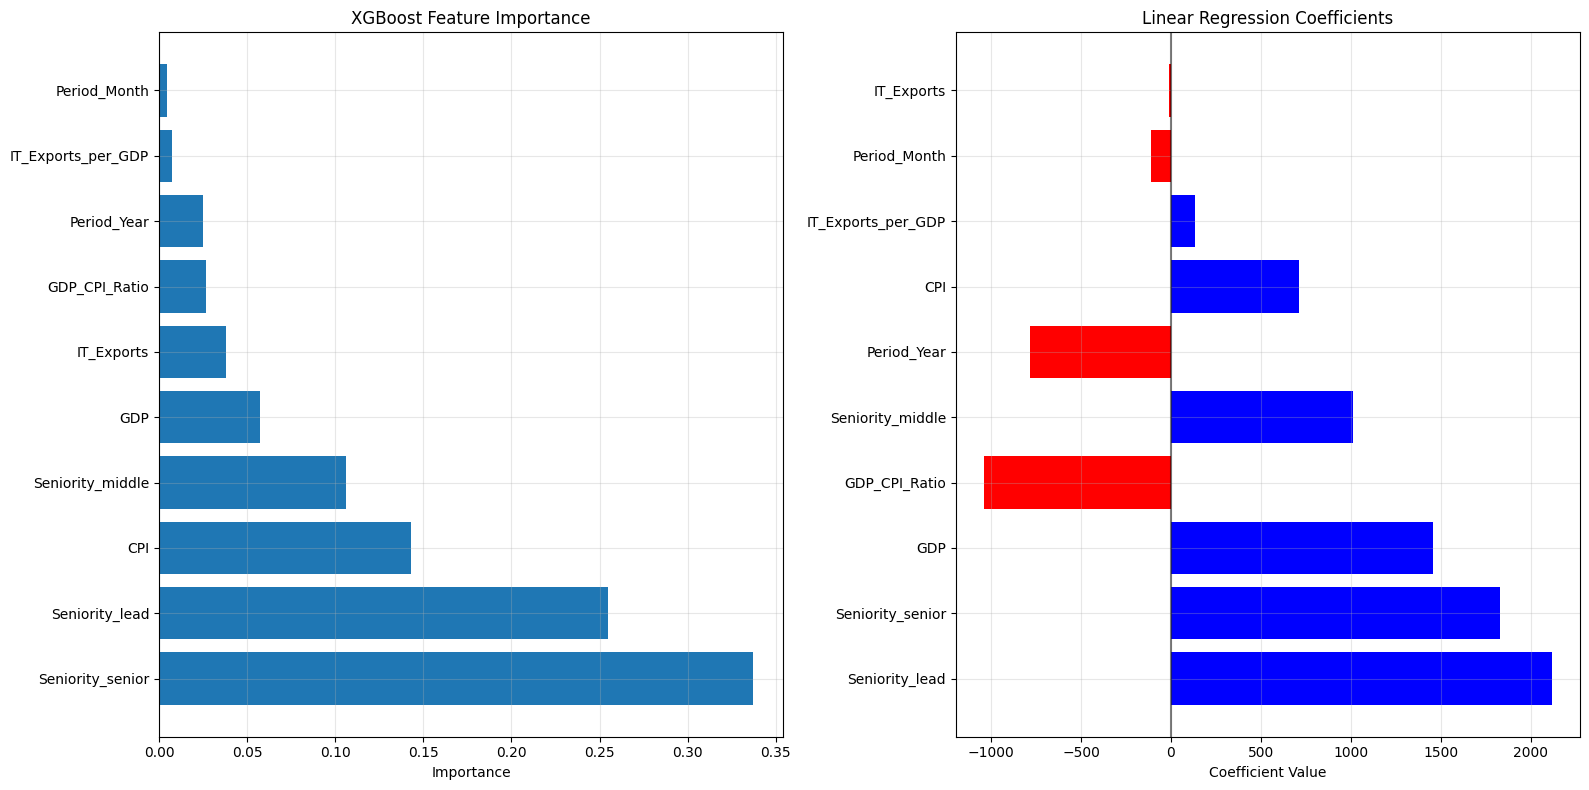

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_xgb_features = xgb_feature_importance.head(10)

axes[0].barh(range(len(top_xgb_features)), top_xgb_features['importance'])
axes[0].set_yticks(range(len(top_xgb_features)))
axes[0].set_yticklabels(top_xgb_features['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('XGBoost Feature Importance')
axes[0].grid(True, alpha=0.3)

top_linear_features = linear_feature_importance.head(10)
colors = ['red' if coef < 0 else 'blue' for coef in top_linear_features['coefficient']]

axes[1].barh(range(len(top_linear_features)), top_linear_features['coefficient'], color=colors)
axes[1].set_yticks(range(len(top_linear_features)))
axes[1].set_yticklabels(top_linear_features['feature'])
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('Linear Regression Coefficients')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
models = {}
for level in df['Seniority'].unique():
    print(f"\n🔄 Training model for {level.capitalize()} level...")
    models[level] = train_ml_model_for_seniority(df, level)
